In [1]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('/content/Dataset of Diabetes.csv')

# Check for missing values
print(data.isnull().sum())

# Handle missing values if any (for simplicity, we'll drop them)
data = data.dropna()

# Check unique values in CLASS column
print("Unique values in CLASS before mapping:", data['CLASS'].unique())

# Strip leading/trailing spaces from the 'CLASS' column
data['CLASS'] = data['CLASS'].str.strip()

# Manually encode CLASS to ensure correct label values
class_mapping = {'N': 0, 'P': 1, 'Y': 2}
data['CLASS'] = data['CLASS'].map(class_mapping)

# Verify the encoding
print("Unique values in CLASS after mapping:", data['CLASS'].unique())

# Check for any invalid entries
invalid_entries = data['CLASS'].isnull().sum()
print("Number of invalid entries in CLASS after mapping:", invalid_entries)

# If there are invalid entries, print them
if invalid_entries > 0:
    print("Invalid entries in CLASS column:", data[data['CLASS'].isnull()])


# Remove rows with invalid CLASS entries
data = data.dropna(subset=['CLASS'])

ID           0
No_Pation    0
Gender       0
AGE          0
Urea         0
Cr           0
HbA1c        0
Chol         0
TG           0
HDL          0
LDL          0
VLDL         0
BMI          0
CLASS        0
dtype: int64
Unique values in CLASS before mapping: ['N' 'N ' 'P' 'Y' 'Y ']
Unique values in CLASS after mapping: [0 1 2]
Number of invalid entries in CLASS after mapping: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   int64  
dtypes: float64(8), int64(5), object(1)
memory usage: 109.5+ KB
None


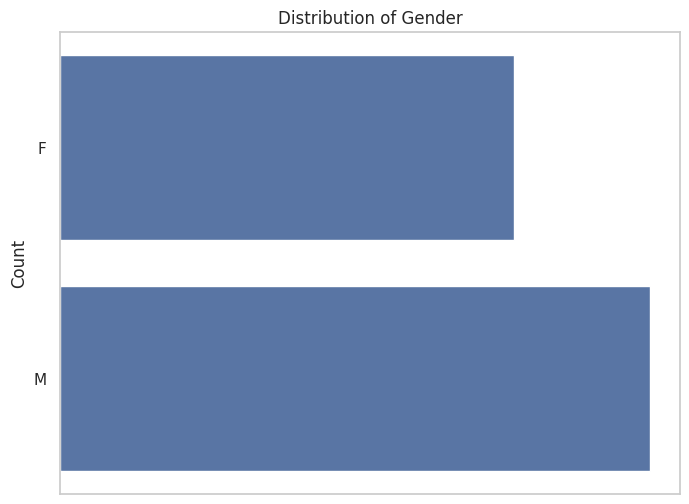

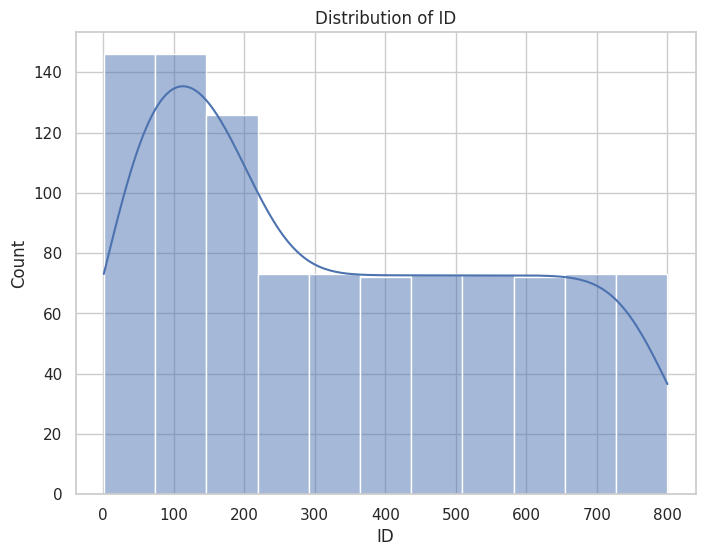

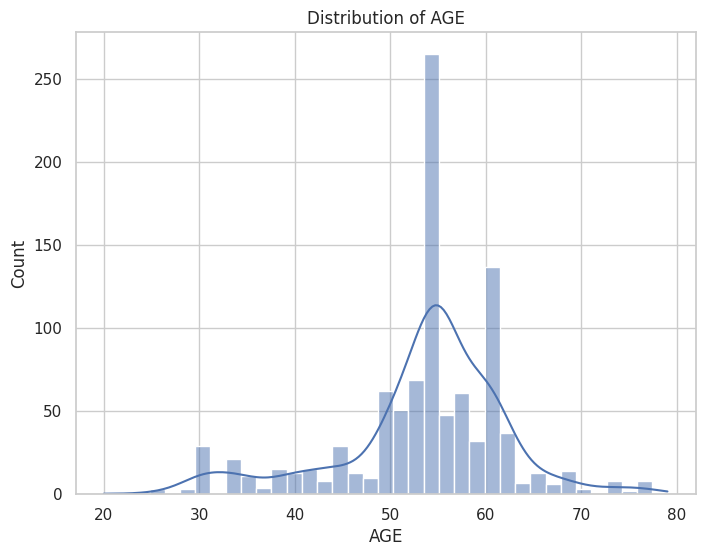

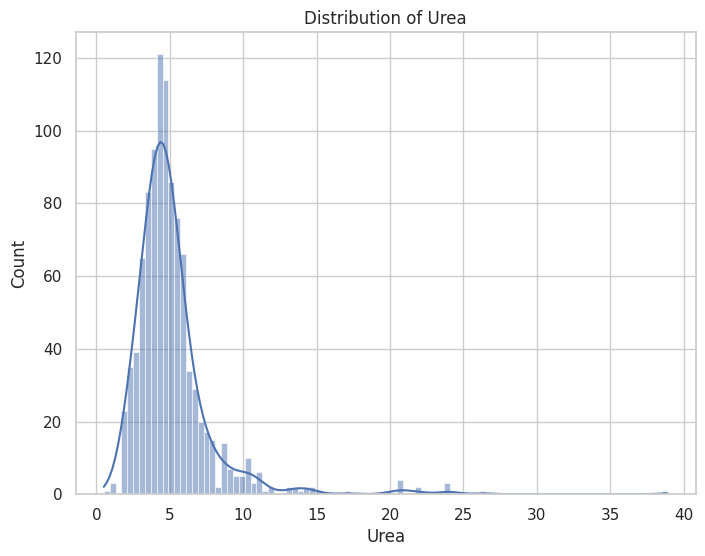

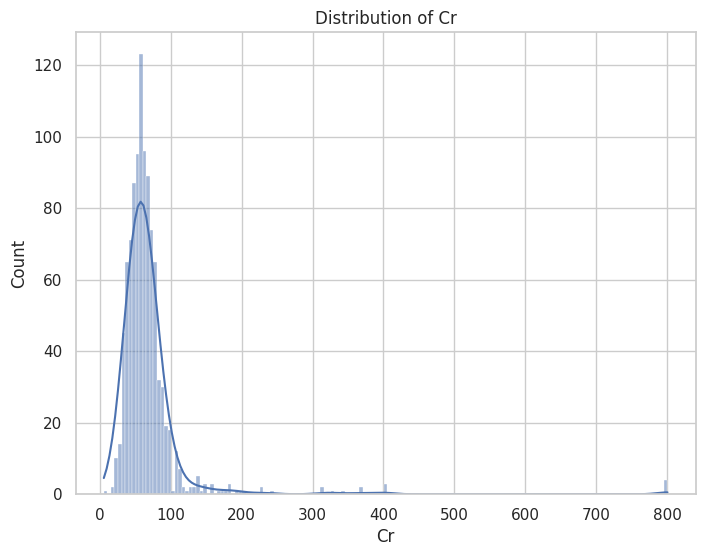

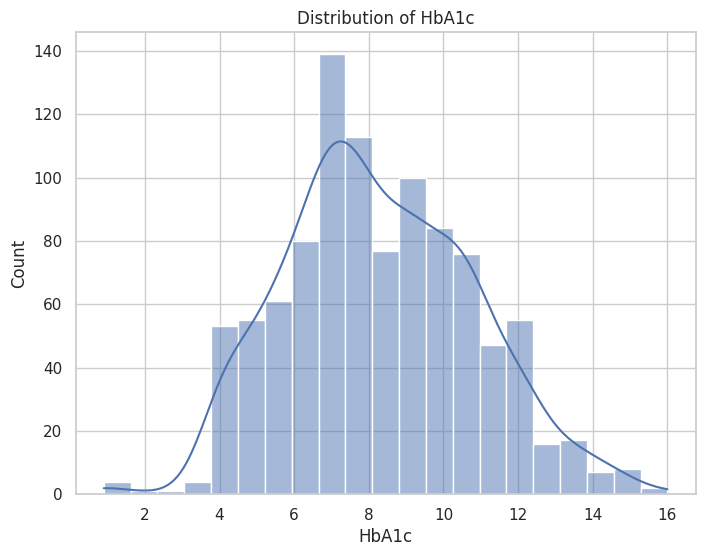

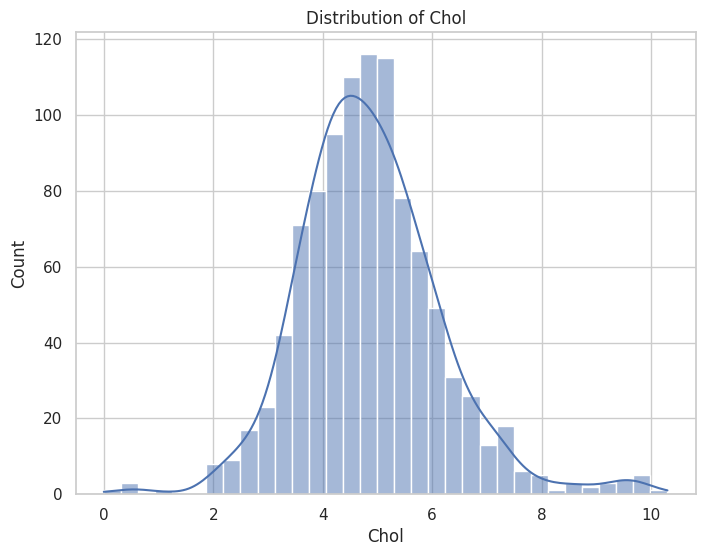

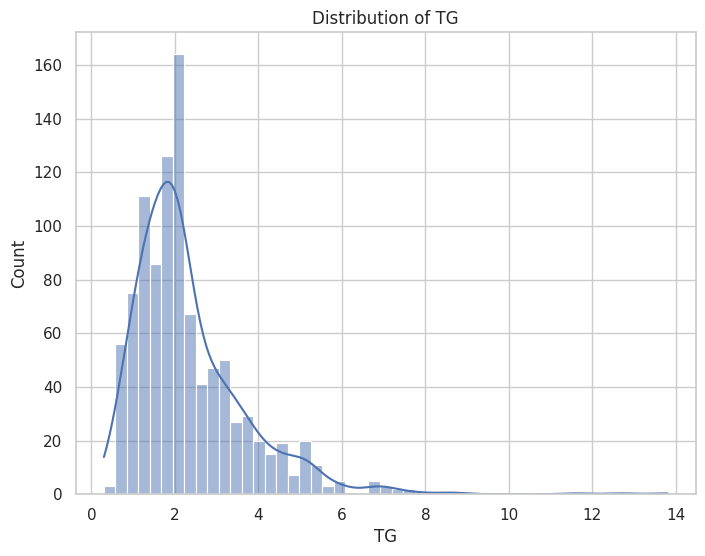

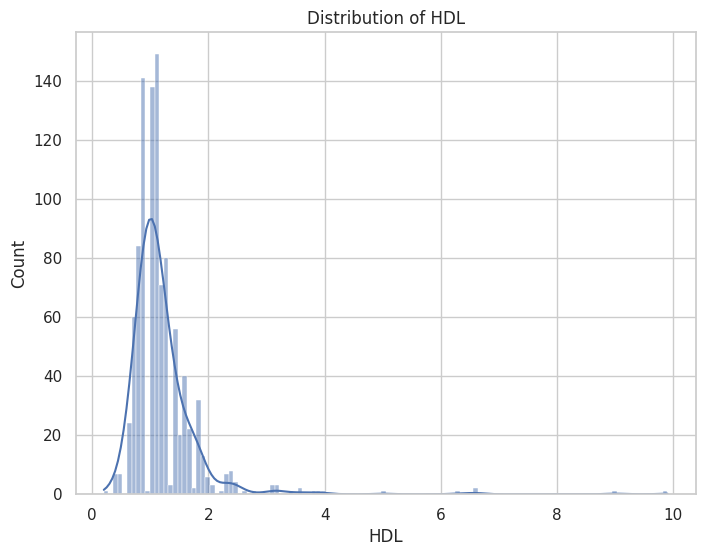

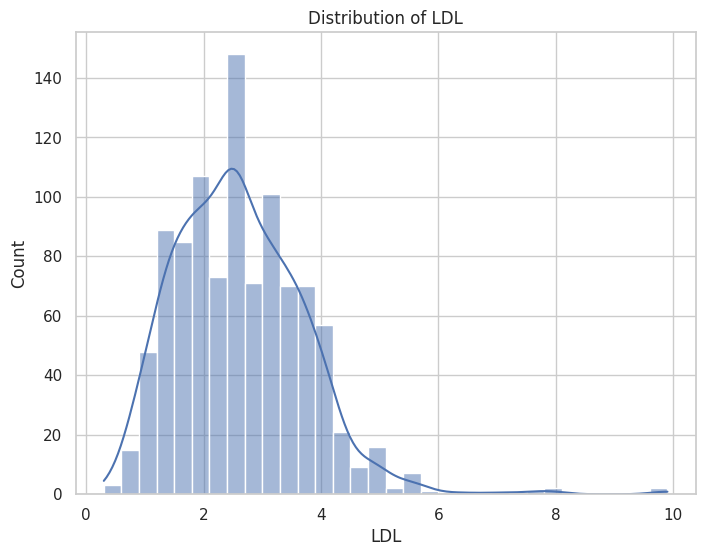

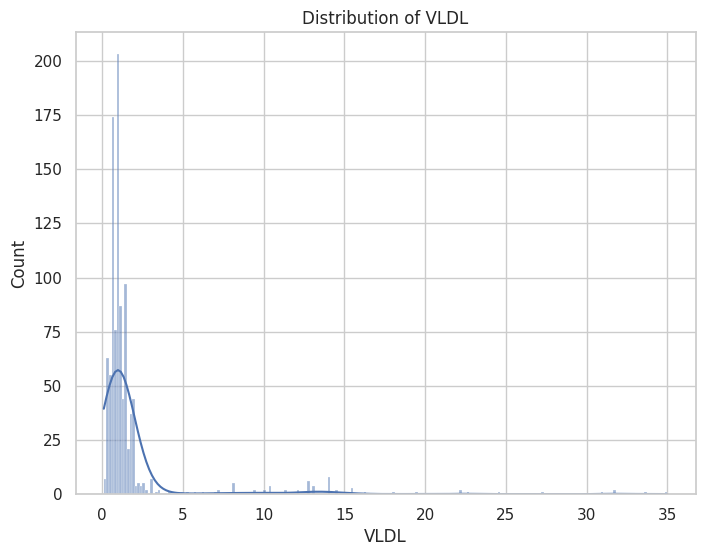

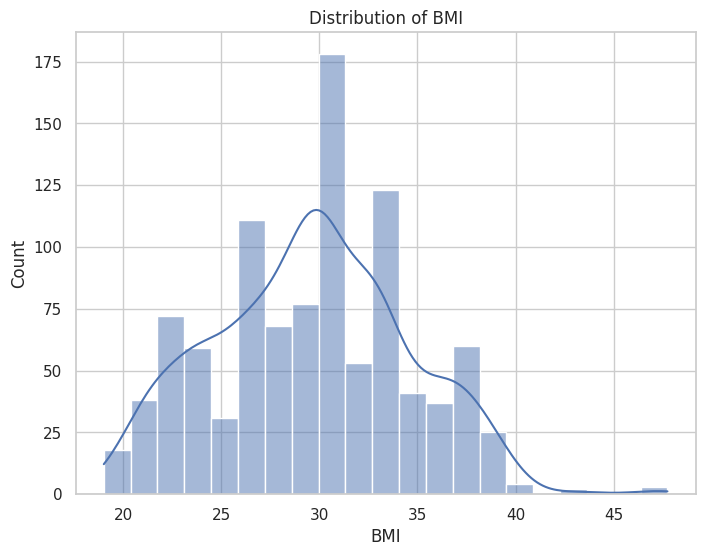

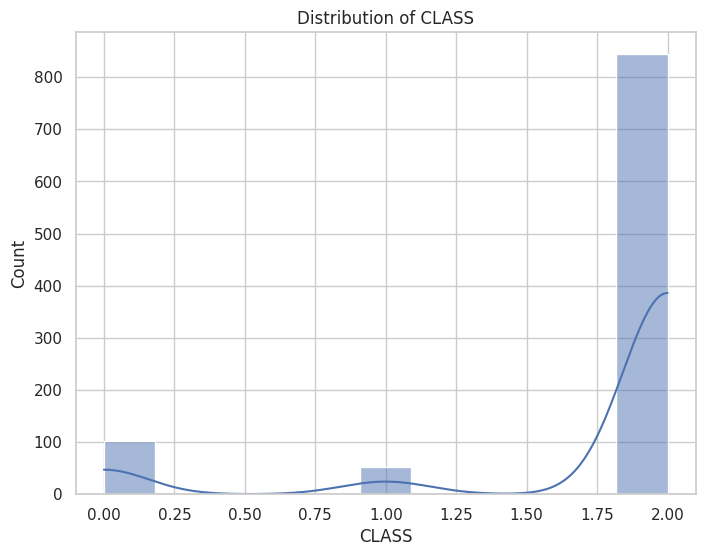

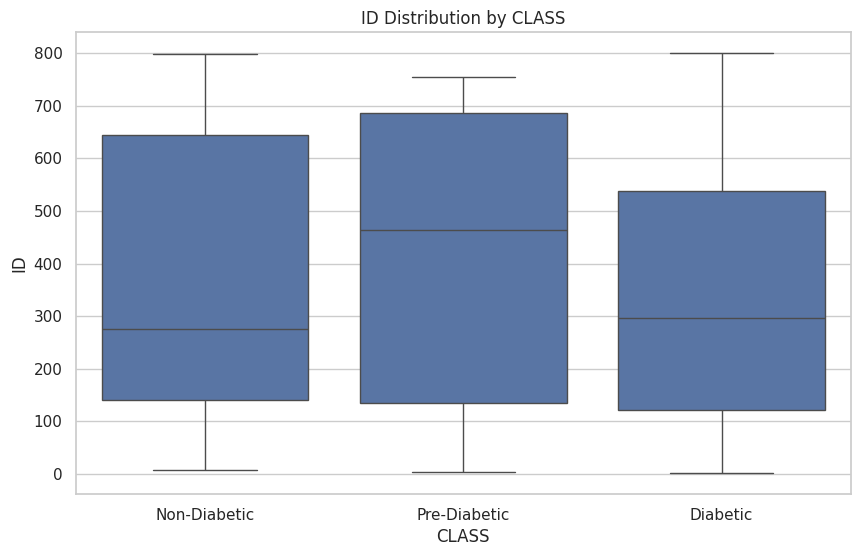

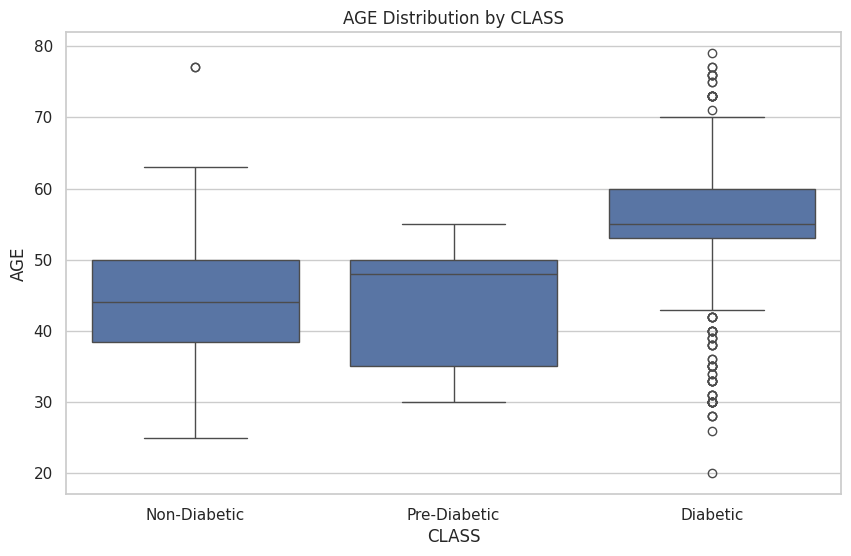

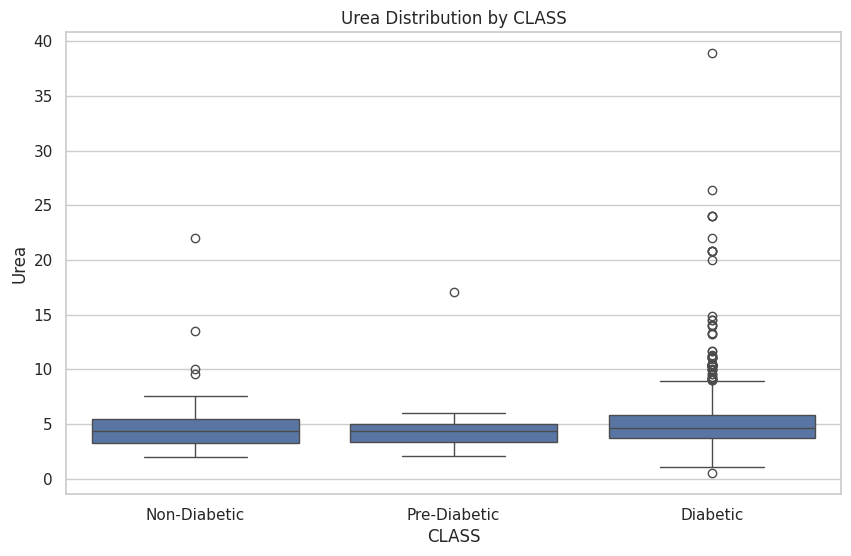

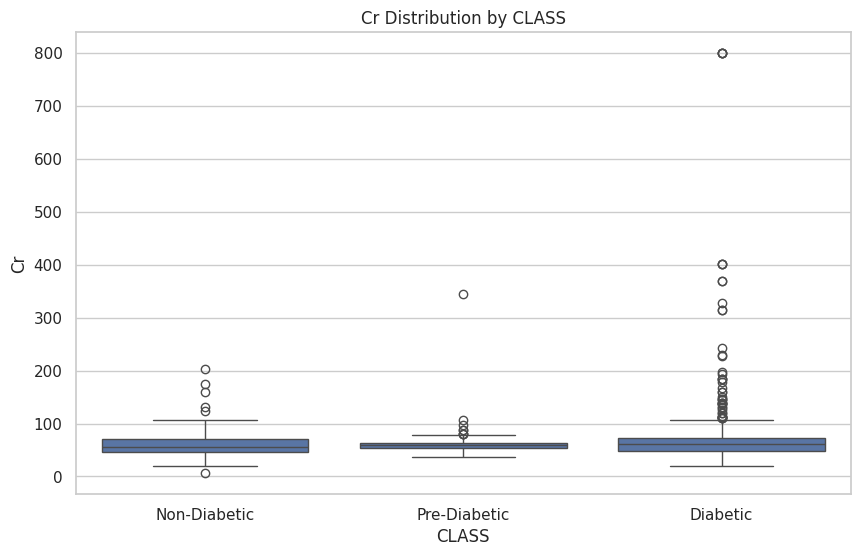

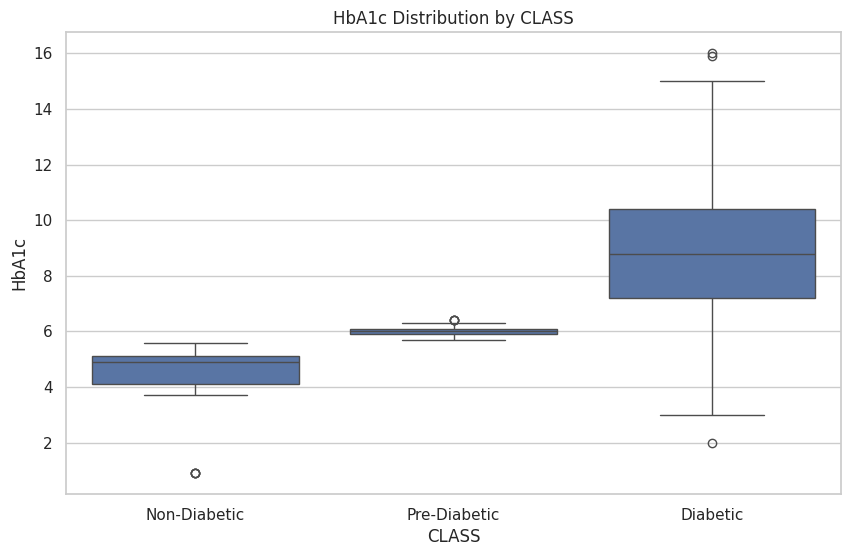

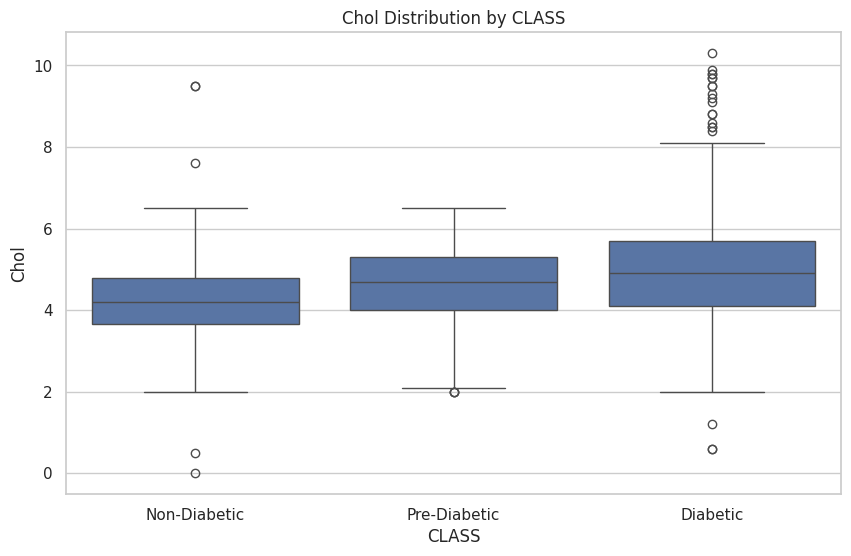

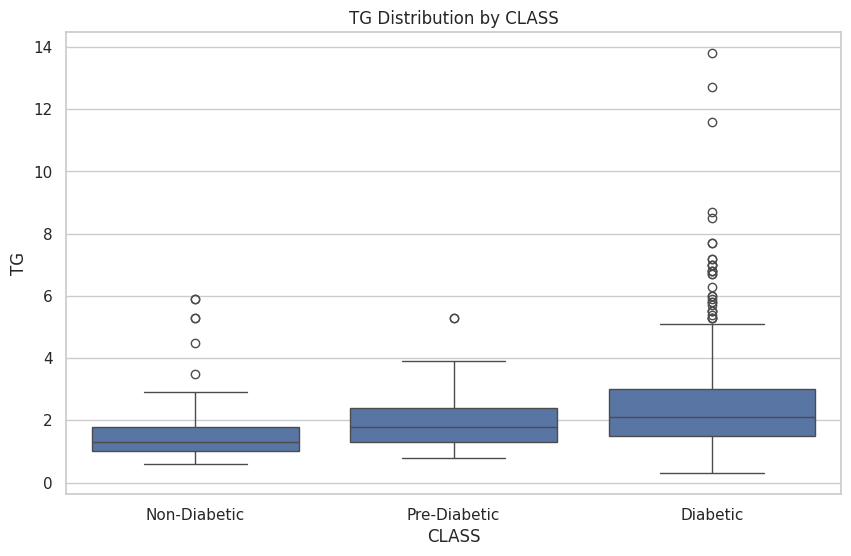

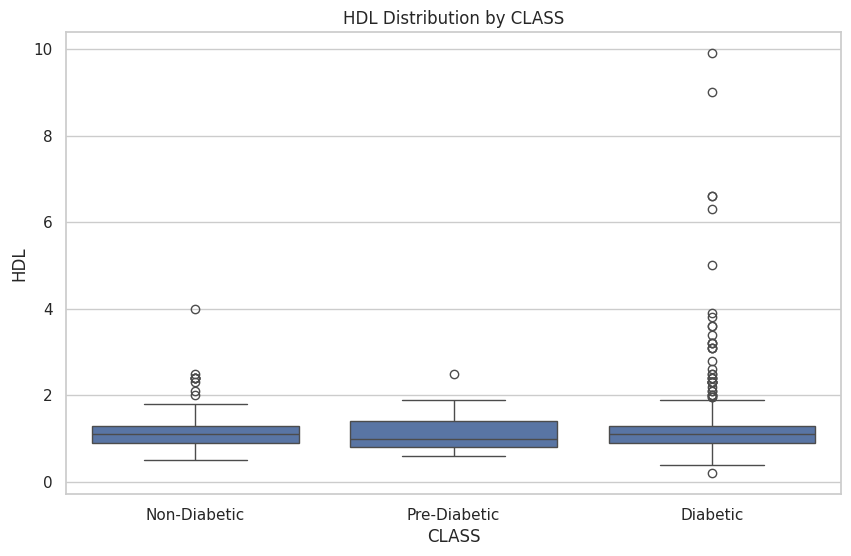

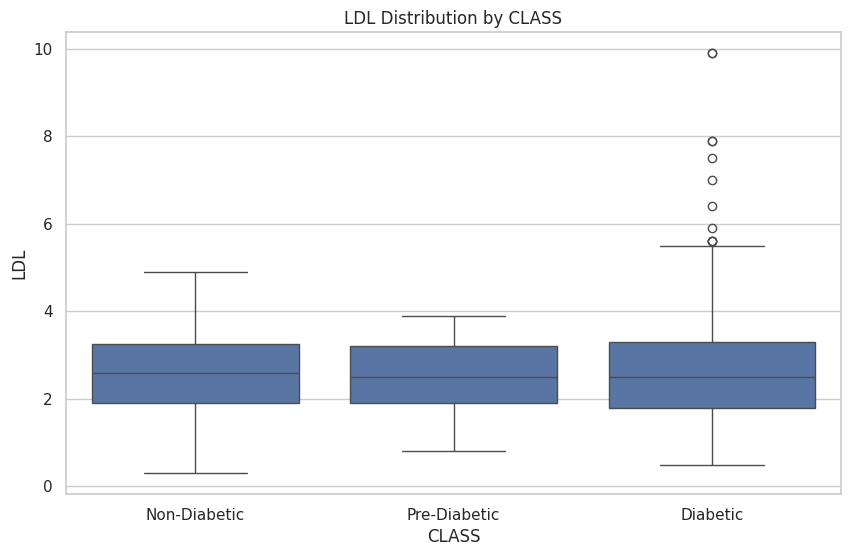

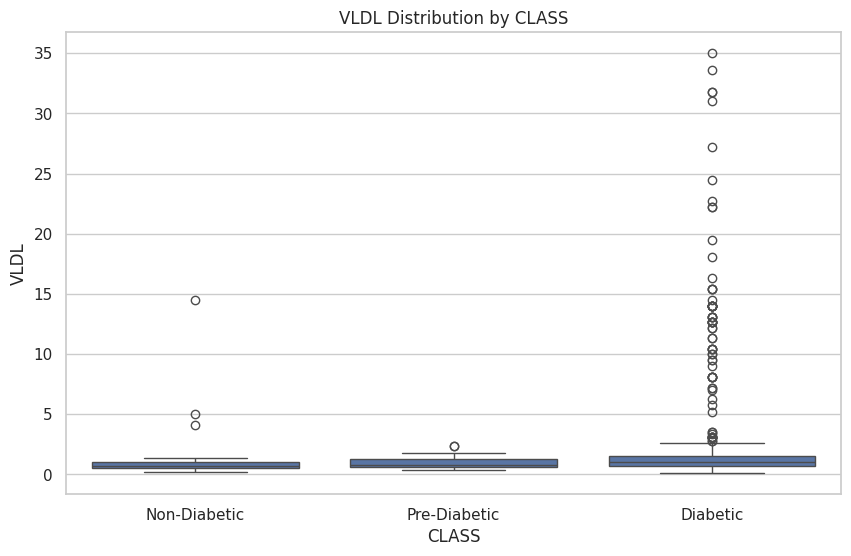

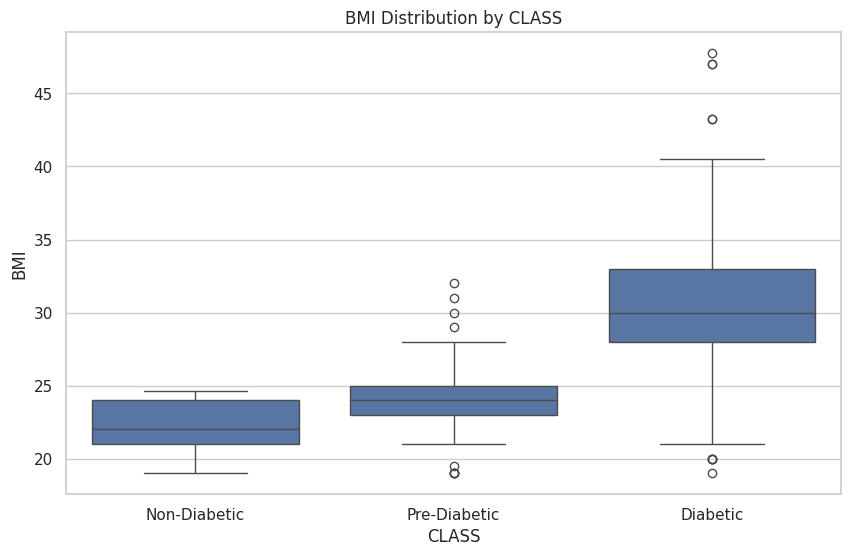

<Figure size 1200x1000 with 0 Axes>

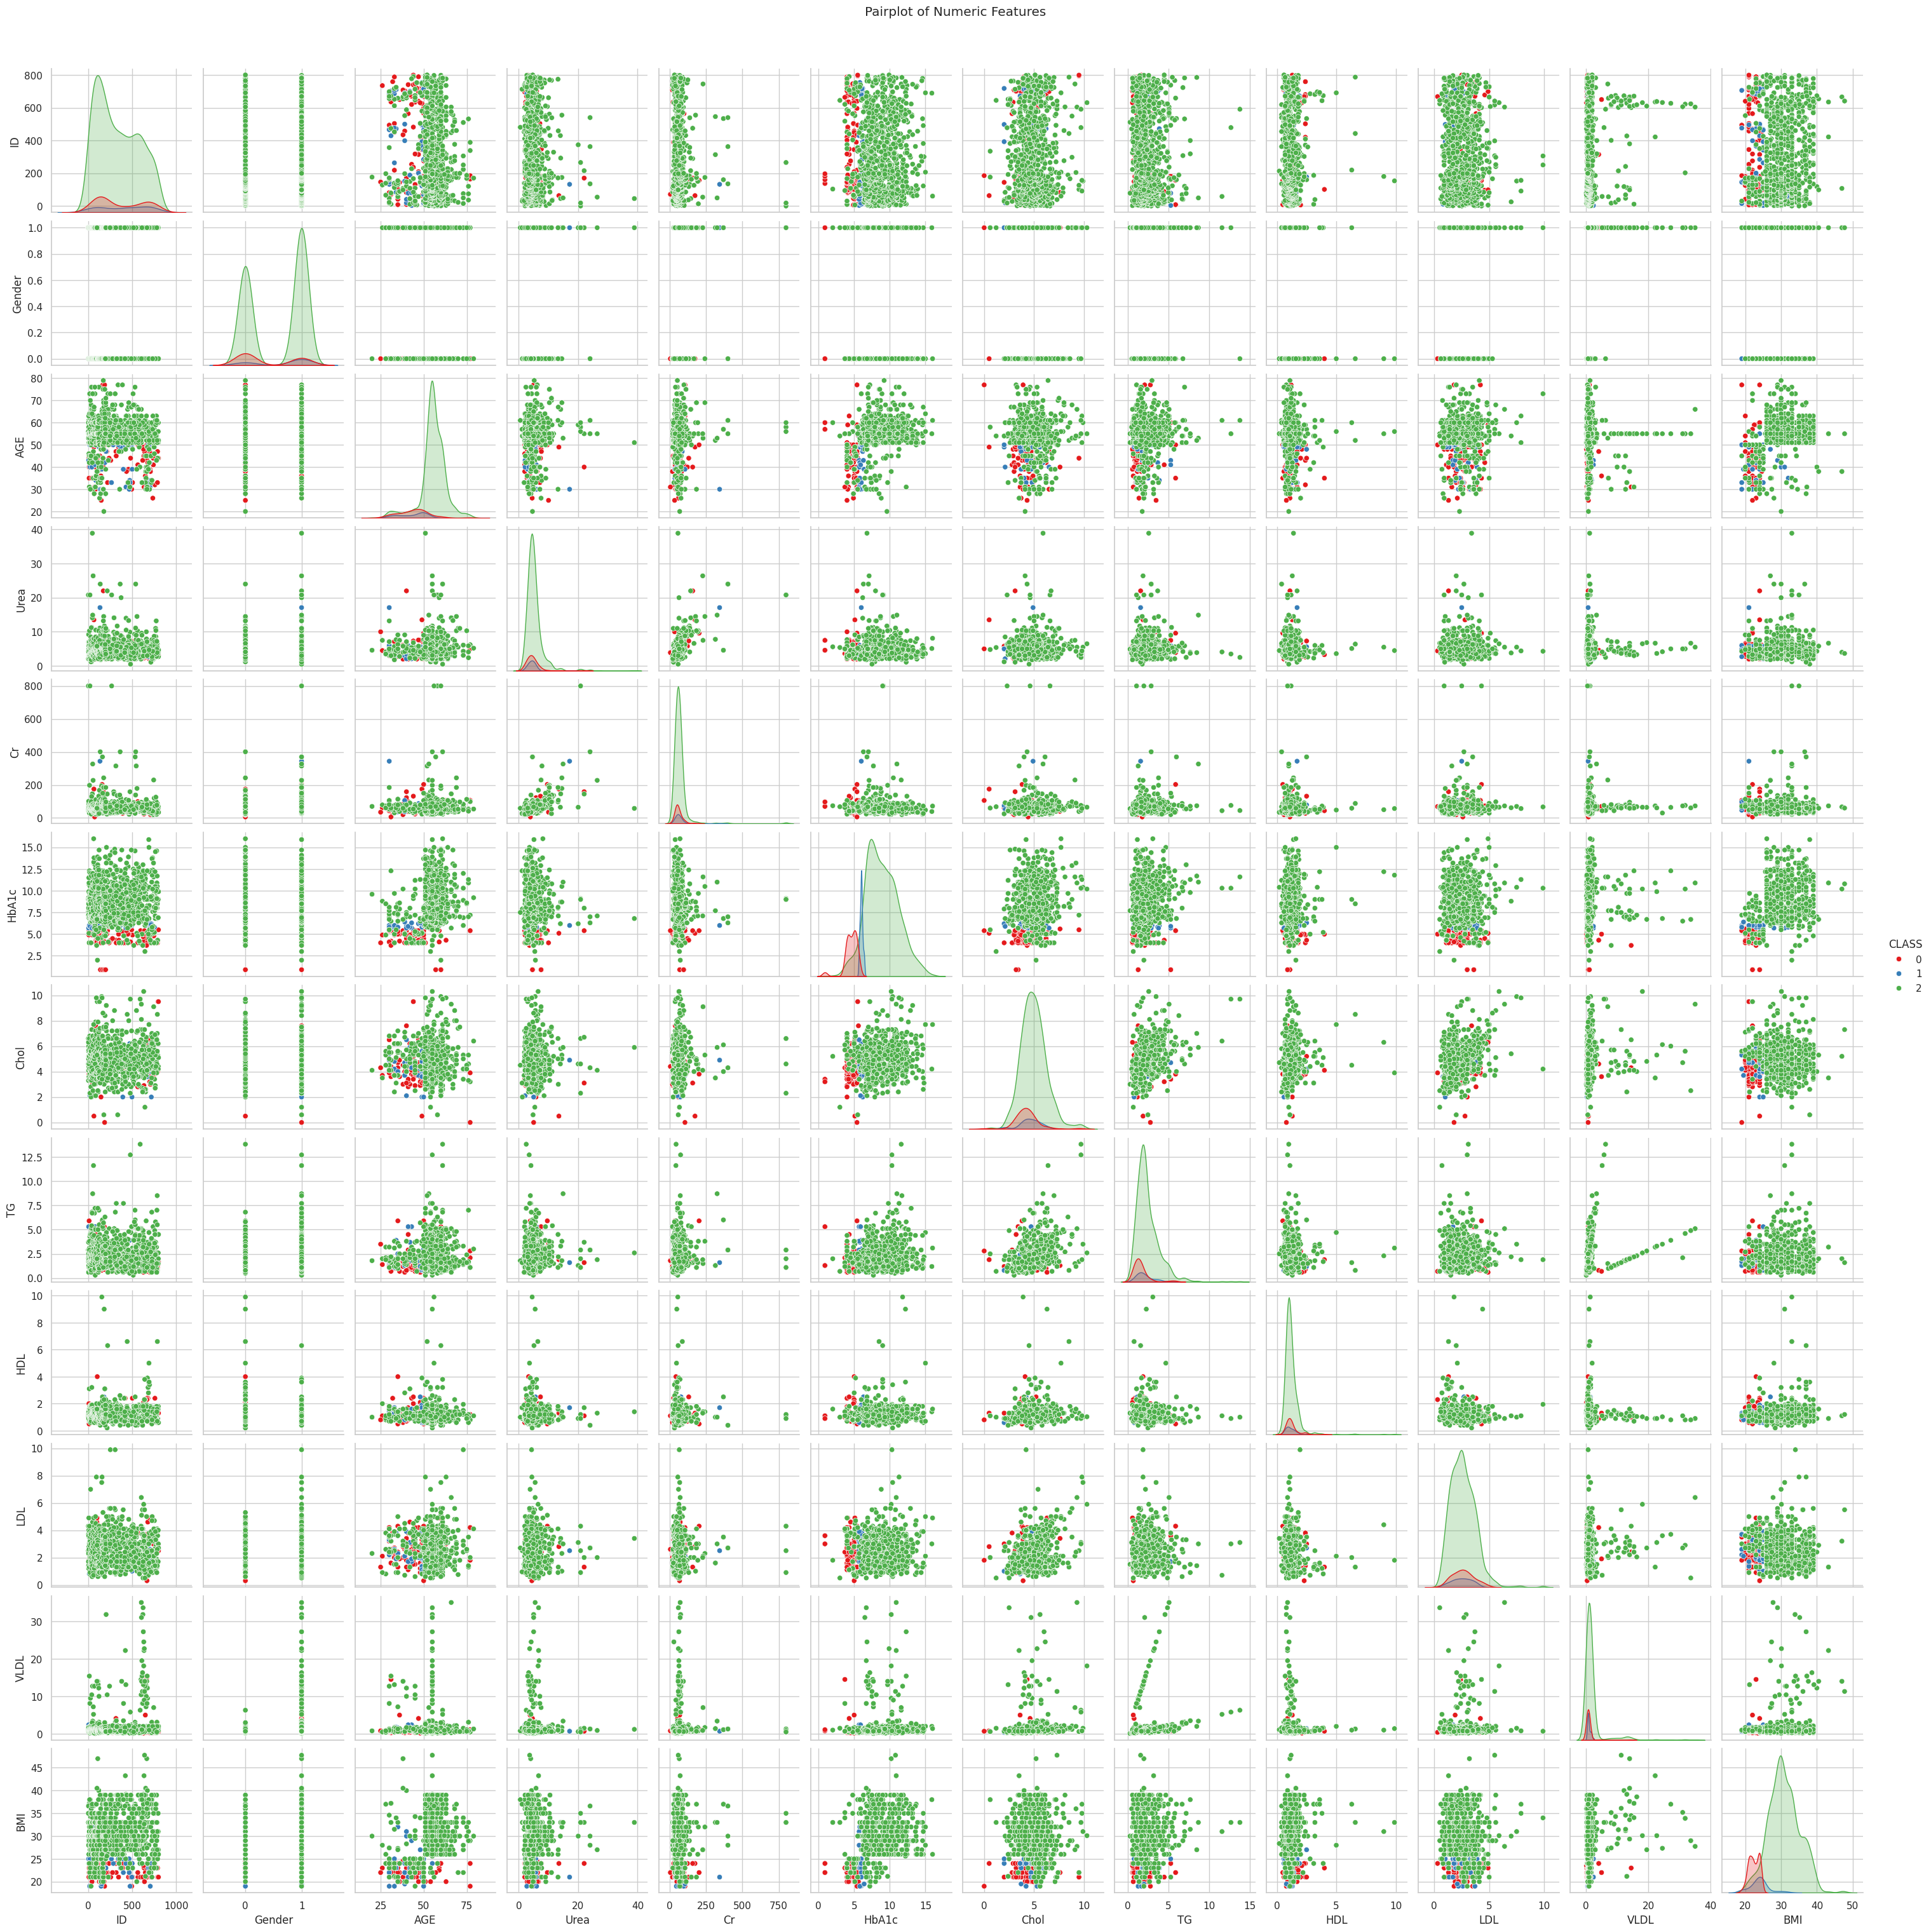

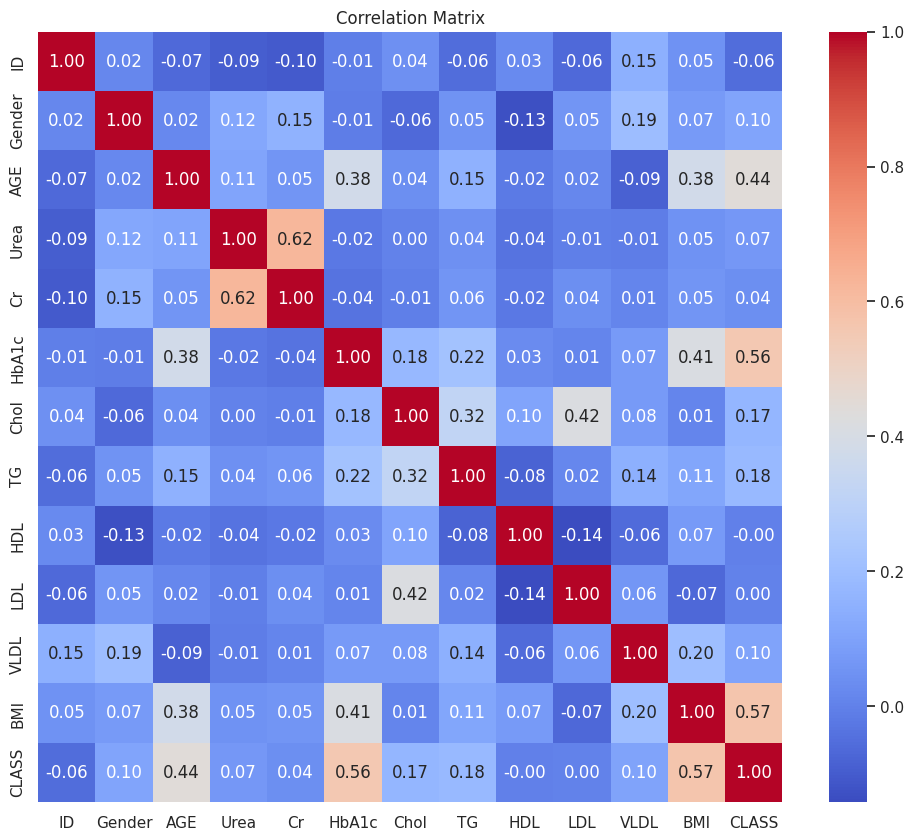

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Set the style of the visualization
sns.set(style="whitegrid")

# Clean the Gender column
data['Gender'] = data['Gender'].str.strip().str.upper()  # Strip spaces and convert to upper case

# Display basic information about the dataset
print(data.info())

# Visualize the distribution of Gender
plt.figure(figsize=(8, 6))
sns.countplot(data['Gender'])
plt.title('Distribution of Gender')
plt.ylabel('Count')
plt.xticks([])  # Remove x-axis labels
plt.xlabel('')  # Remove x-axis label
plt.show()

# Visualize the distribution of each numeric feature (excluding No_Pation)
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
numeric_features = numeric_features.drop('No_Pation')  # Exclude 'No_Pation'

for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

# Visualize the relationship between each numeric feature and CLASS (excluding No_Pation)
for feature in numeric_features:
    if feature != 'CLASS':
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='CLASS', y=feature, data=data)
        plt.title(f'{feature} Distribution by CLASS')
        plt.xlabel('CLASS')
        plt.ylabel(feature)
        plt.xticks(ticks=[0, 1, 2], labels=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic'])
        plt.show()

# Convert categorical columns to numeric for correlation matrix
data_encoded = data.copy()
label_encoder = LabelEncoder()
data_encoded['Gender'] = label_encoder.fit_transform(data_encoded['Gender'])

# Visualize the pairplot of numeric features (excluding No_Pation)
plt.figure(figsize=(12, 10))
sns.pairplot(data_encoded.drop(columns=['No_Pation']), hue='CLASS', diag_kind='kde', palette='Set1')
plt.suptitle('Pairplot of Numeric Features', y=1.02)
plt.show()

# Visualize the correlation matrix (excluding No_Pation)
plt.figure(figsize=(12, 10))
correlation_matrix = data_encoded.drop(columns=['No_Pation']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode categorical data
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])

# Define feature variables and target variable
X = data.drop(columns=['No_Pation', 'CLASS'])
y = data['CLASS'].astype(int)  # Ensure y is of integer type

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Build the ANN model with L2 regularization
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(3, activation='softmax'))  # 3 classes: Diabetic, Non-Diabetic, Pre-Diabetic

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10,  restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=1000, batch_size=10, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/1000
64/64 [==============================] - 1s 6ms/step - loss: 0.9417 - accuracy: 0.8344 - val_loss: 0.7969 - val_accuracy: 0.8500
Epoch 2/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.7389 - accuracy: 0.8422 - val_loss: 0.6654 - val_accuracy: 0.8500
Epoch 3/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.6351 - accuracy: 0.8422 - val_loss: 0.5881 - val_accuracy: 0.8500
Epoch 4/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.8422 - val_loss: 0.5340 - val_accuracy: 0.8500
Epoch 5/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.5212 - accuracy: 0.8422 - val_loss: 0.4927 - val_accuracy: 0.8500
Epoch 6/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.4840 - accuracy: 0.8484 - val_loss: 0.4586 - val_accuracy: 0.8750
Epoch 7/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.4535 - accuracy: 0.8656 - val_loss: 0.4287 - val_accuracy: 0.8875
Epoch 

7/7 [==============================] - 0s 2ms/step
Confusion Matrix:
[[ 17   2   2]
 [  2   6   2]
 [  1   0 168]]

Accuracy: 0.955
Precision (macro-average): 0.8589147286821706
Precision (micro-average): 0.955
Precision (weighted-average): 0.9520988372093022


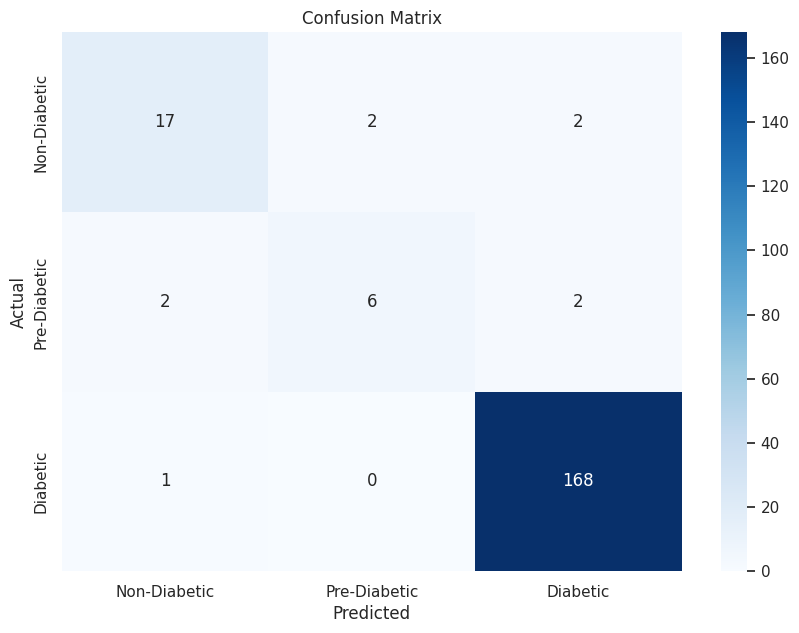

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, output_dict=True)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Calculate different types of precision
precision_macro = precision_score(y_test, y_pred_classes, average='macro')
precision_micro = precision_score(y_test, y_pred_classes, average='micro')
precision_weighted = precision_score(y_test, y_pred_classes, average='weighted')

# Print Confusion Matrix, Accuracy, and Precisions
print("Confusion Matrix:")
print(conf_matrix)
print(f"\nAccuracy: {accuracy}")
print(f"Precision (macro-average): {precision_macro}")
print(f"Precision (micro-average): {precision_micro}")
print(f"Precision (weighted-average): {precision_weighted}")

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

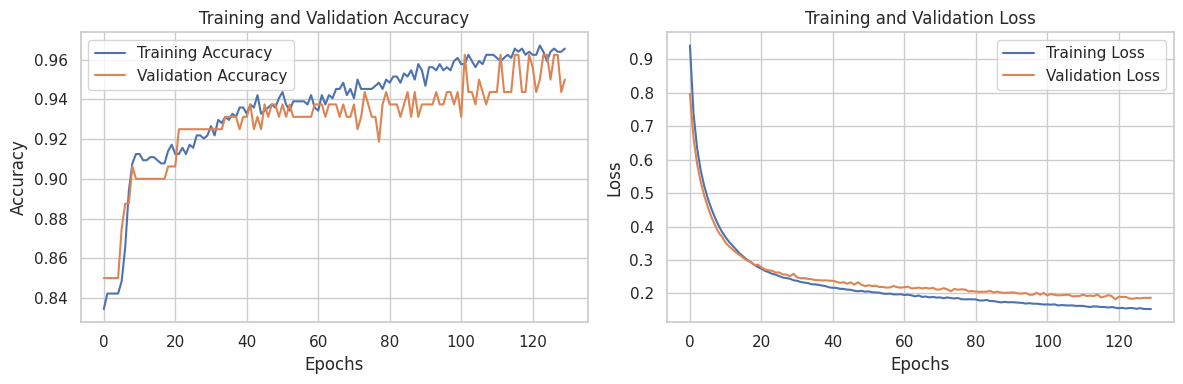

In [6]:
# Visualize training history
history_dict = history.history

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()